In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import random
import re
import os
import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.utils import class_weight
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from sklearn.metrics import recall_score
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.python.keras import losses
from skimage.transform import resize
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import EfficientNetB0
from keras import backend as K
from skimage.transform import resize
from tensorflow.keras import layers, models
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from tensorflow.keras.regularizers import l2
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization, Activation, concatenate, GlobalAveragePooling2D, AveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D,Dropout

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#Carrego les imatges

ruta_no ='/kaggle/input/brain-mri-images-for-brain-tumor-detection/no'
ruta_yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes'

labels = ['No Tumor', 'Tumor']


no_list = os.listdir(ruta_no)
yes_list = os.listdir(ruta_yes)

#Defineixo on guardaré les imatges
X = []
y = []
IMG_SIZE = (224, 224)

# Carrego les imatges amb tumor
for i in range(len(yes_list)):
    file_path = os.path.join(ruta_yes, yes_list[i])

    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  
        X.append(img_resized)
        y.append(1)
    else:
        print(f"File not found: {file_path}")

# Carrego les imatges sense tumor
for i in range(len(no_list)):
    file_path = os.path.join(ruta_no, no_list[i])
    if os.path.exists(file_path):
        img = plt.imread(file_path)
        img_resized = resize(img, IMG_SIZE + (3,))  
        X.append(img_resized)
        y.append(0)
    else:
        print(f"File not found: {file_path}")

X = np.array(X)
y = np.array(y)

# Shuffle data
X, y = shuffle(X, y, random_state=42)

In [3]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [4]:
def plot_sample_images(X, y, n=10):
    #np.random.seed(42)  # Para reproducibilidad, establecer una semilla aleatoria fija
    for label in [0, 1]:
        # Obtener índices de imágenes con la etiqueta correspondiente
        indices = np.where(y == label)[0]
        
        # Seleccionar aleatoriamente n índices
        selected_indices = np.random.choice(indices, n, replace=False)
        
        columns_n = 5
        rows_n = int(n / columns_n)

        plt.figure(figsize=(10, 8))

        i = 1  # índice actual
        for idx in selected_indices:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(X[idx])

            # Eliminar marcas
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()




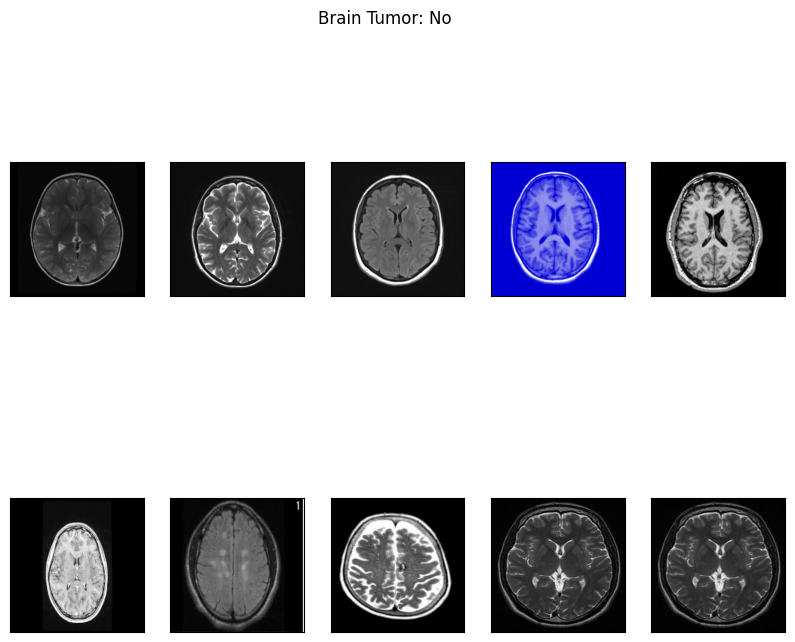

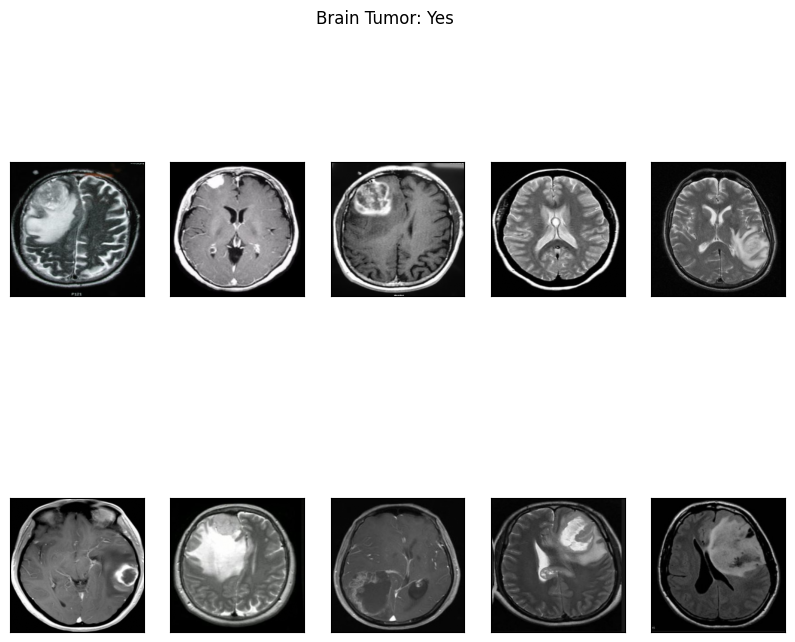

In [5]:
plot_sample_images(X, y)

In [6]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [8]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 177
number of validation examples = 38
number of test examples = 38


In [9]:
# balanceig de dades:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convierte los pesos de clase a un diccionario
class_weights_dict = {i: w for i, w in enumerate(class_weights)}

In [10]:
# asignem els hiperparametres corresponents a les imatges.
IMAGE_WIDTH=224 # amplada de les fotos
IMAGE_HEIGHT=224 # alçada de les fotos
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT) # definim el tamany total de les imatges. 
IMAGE_CHANNELS=3 # asignem que la imatge te 3 canals ja que és una imatge en color i per tant te una capa RED, una GREEN i una BLUE.
batch_size=16
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

In [11]:
def build_model(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((2, 2))(X_input)
    
    X = Conv2D(32, (7, 7), strides=(1, 1))(X)
    X = BatchNormalization(axis=3, name='bn0')(X)
    X = Activation('relu')(X)
    
    X = MaxPooling2D((4, 4))(X)
    X = MaxPooling2D((4, 4))(X)
    
    X = Flatten()(X)
    X = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(X)
    X = tf.keras.layers.Dropout(0.5)(X) 
    
    X = Dense(1, activation='sigmoid')(X)
    
    model = Model(inputs=X_input, outputs=X)
    
    return model

In [12]:
IMG_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 228, 228, 3)       0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 222, 222, 32)      128       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 32)        0         
 D)                                                          

In [13]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/50
6/6 [==============================] - 7s 161ms/step - loss: 4.6558 - accuracy: 0.5763 - val_loss: 2.8566 - val_accuracy: 0.6053
Epoch 2/50
6/6 [==============================] - 0s 54ms/step - loss: 2.9983 - accuracy: 0.7345 - val_loss: 2.6477 - val_accuracy: 0.6053
Epoch 3/50
6/6 [==============================] - 0s 52ms/step - loss: 2.7629 - accuracy: 0.7458 - val_loss: 2.5121 - val_accuracy: 0.6579
Epoch 4/50
6/6 [==============================] - 0s 54ms/step - loss: 2.4173 - accuracy: 0.6836 - val_loss: 2.3783 - val_accuracy: 0.6579
Epoch 5/50
6/6 [==============================] - 0s 53ms/step - loss: 2.3083 - accuracy: 0.6949 - val_loss: 2.2413 - val_accuracy: 0.6053
Epoch 6/50
6/6 [==============================] - 0s 54ms/step - loss: 2.0429 - accuracy: 0.7458 - val_loss: 2.1475 - val_accuracy: 0.5789
Epoch 7/50
6/6 [==============================] - 0s 56ms/step - loss: 1.9504 - accuracy: 0.8136 - val_loss: 2.0704 - val_accuracy: 0.6053
Epoch 8/50
6/6 [==========

In [14]:
# Crear el modelo base preentrenado (VGG16 en este caso)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas al modelo base
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.01))(x)

# Crear el modelo completo
model_vgg16 = Model(inputs=base_model.input, outputs=output)
model_vgg16.summary()



58889256/58889256 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [15]:
# VGG16
model_vgg16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_vgg16 = model_vgg16.fit(x=X_train, y=y_train, batch_size=32, epochs=50,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    class_weight=class_weights_dict)

Epoch 1/50
6/6 [==============================] - 11s 945ms/step - loss: 0.7208 - accuracy: 0.7288 - val_loss: 4.5629 - val_accuracy: 0.5789
Epoch 2/50
6/6 [==============================] - 1s 148ms/step - loss: 0.1931 - accuracy: 0.9096 - val_loss: 4.4827 - val_accuracy: 0.5789
Epoch 3/50
6/6 [==============================] - 1s 160ms/step - loss: 0.1816 - accuracy: 0.9379 - val_loss: 3.8382 - val_accuracy: 0.6053
Epoch 4/50
6/6 [==============================] - 1s 153ms/step - loss: 0.1093 - accuracy: 0.9774 - val_loss: 3.1917 - val_accuracy: 0.6579
Epoch 5/50
6/6 [==============================] - 1s 145ms/step - loss: 0.1124 - accuracy: 0.9718 - val_loss: 2.7002 - val_accuracy: 0.6579
Epoch 6/50
6/6 [==============================] - 1s 146ms/step - loss: 0.0900 - accuracy: 0.9831 - val_loss: 2.4956 - val_accuracy: 0.6579
Epoch 7/50
6/6 [==============================] - 1s 143ms/step - loss: 0.0671 - accuracy: 0.9944 - val_loss: 2.3433 - val_accuracy: 0.6579
Epoch 8/50
6/6 [===

In [16]:
# Predecir en los conjuntos de entrenamiento y validación
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)

# Aplicar umbral de decisión si es necesario (por ejemplo, para convertir probabilidades en clases binarias)
threshold = 0.5
y_train_pred_binary = (y_train_pred > threshold).astype(int)
y_val_pred_binary = (y_val_pred > threshold).astype(int)

# Calcular el recall utilizando scikit-learn
train_recall = recall_score(y_train, y_train_pred_binary)
val_recall = recall_score(y_val, y_val_pred_binary)

print("Sensibilitat en el conjunt d'entrenament:", train_recall)
print("Sensibilitat en el conjunt de validació:", val_recall)

2/2 [==============================] - 0s 15ms/step
Sensibilitat en el conjunt d'entrenament: 0.45614035087719296
Sensibilitat en el conjunt de validació: 0.5


In [17]:
# Predecir en los conjuntos de entrenamiento y validación
y_train_pred = model_vgg16.predict(X_train)
y_val_pred = model_vgg16.predict(X_val)

# Aplicar umbral de decisión si es necesario (por ejemplo, para convertir probabilidades en clases binarias)
threshold = 0.5
y_train_pred_binary_vgg = (y_train_pred > threshold).astype(int)
y_val_pred_binary_vgg = (y_val_pred > threshold).astype(int)

# Calcular el recall utilizando scikit-learn
train_recall_vgg = recall_score(y_train, y_train_pred_binary_vgg)
val_recall_vgg = recall_score(y_val, y_val_pred_binary_vgg)

print("Sensibilitat en el conjunt d'entrenament:", train_recall_vgg)
print("Sensibilitat en el conjunt de validació:", val_recall_vgg)

2/2 [==============================] - 0s 103ms/step
Sensibilitat en el conjunt d'entrenament: 1.0
Sensibilitat en el conjunt de validació: 1.0


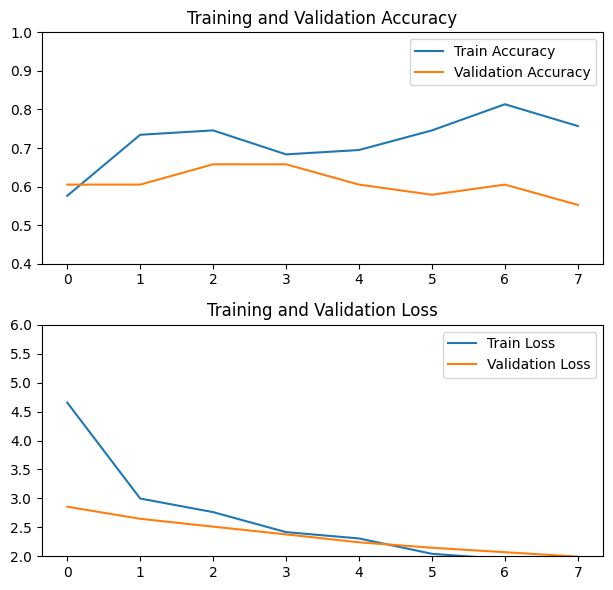

In [18]:
# Obtener métricas de entrenamiento y validación
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráficos
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0.4,1)

# Gráfico de pérdida
plt.subplot(2, 2, 3)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(2,6)

# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()

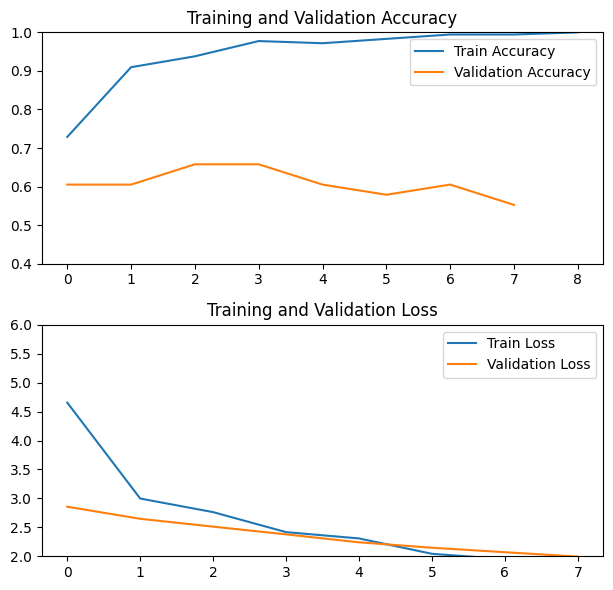

In [19]:
# VGG16
# Obtener métricas de entrenamiento y validación
train_acc = history_vgg16.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear gráficos
plt.figure(figsize=(12, 6))

# Gráfico de precisión
plt.subplot(2, 2, 1)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(0.4,1)

# Gráfico de pérdida
plt.subplot(2, 2, 3)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(2,6)


# Ajustar diseño y mostrar gráficos
plt.tight_layout()
plt.show()


In [20]:
import matplotlib.pyplot as plt

# Función para graficar la historia de entrenamiento en una cuadrícula de 2x2
def plot_training_history_dual(model_history, vgg_history):
    plt.figure(figsize=(16, 12))

    # Gráfico de pérdida del modelo 
    plt.subplot(2, 2, 1)
    plt.plot(model_history.history['loss'], label='Training Loss (Model)')
    plt.plot(model_history.history['val_loss'], label='Validation Loss (Model)')
    plt.title('Training and Validation Loss (Model)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(1,6)

    # Gráfico de precisión del modelo
    plt.subplot(2, 2, 3)
    plt.plot(model_history.history['accuracy'], label='Training Accuracy (Model)')
    plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy (Model)')
    plt.title('Training and Validation Accuracy (Model)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4,1)


    # Gráfico de pérdida de VGG16 
    plt.subplot(2, 2, 2)
    plt.plot(vgg_history.history['loss'], label='Training Loss (VGG16)')
    plt.plot(vgg_history.history['val_loss'], label='Validation Loss (VGG16)')
    plt.title('Training and Validation Loss (VGG16)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    

    # Gráfico de precisión de VGG16 
    plt.subplot(2, 2, 4)
    plt.plot(vgg_history.history['accuracy'], label='Training Accuracy (VGG16)')
    plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy (VGG16)')
    plt.title('Training and Validation Accuracy (VGG16)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.ylim(0.4,1)

    plt.tight_layout()
    plt.show()

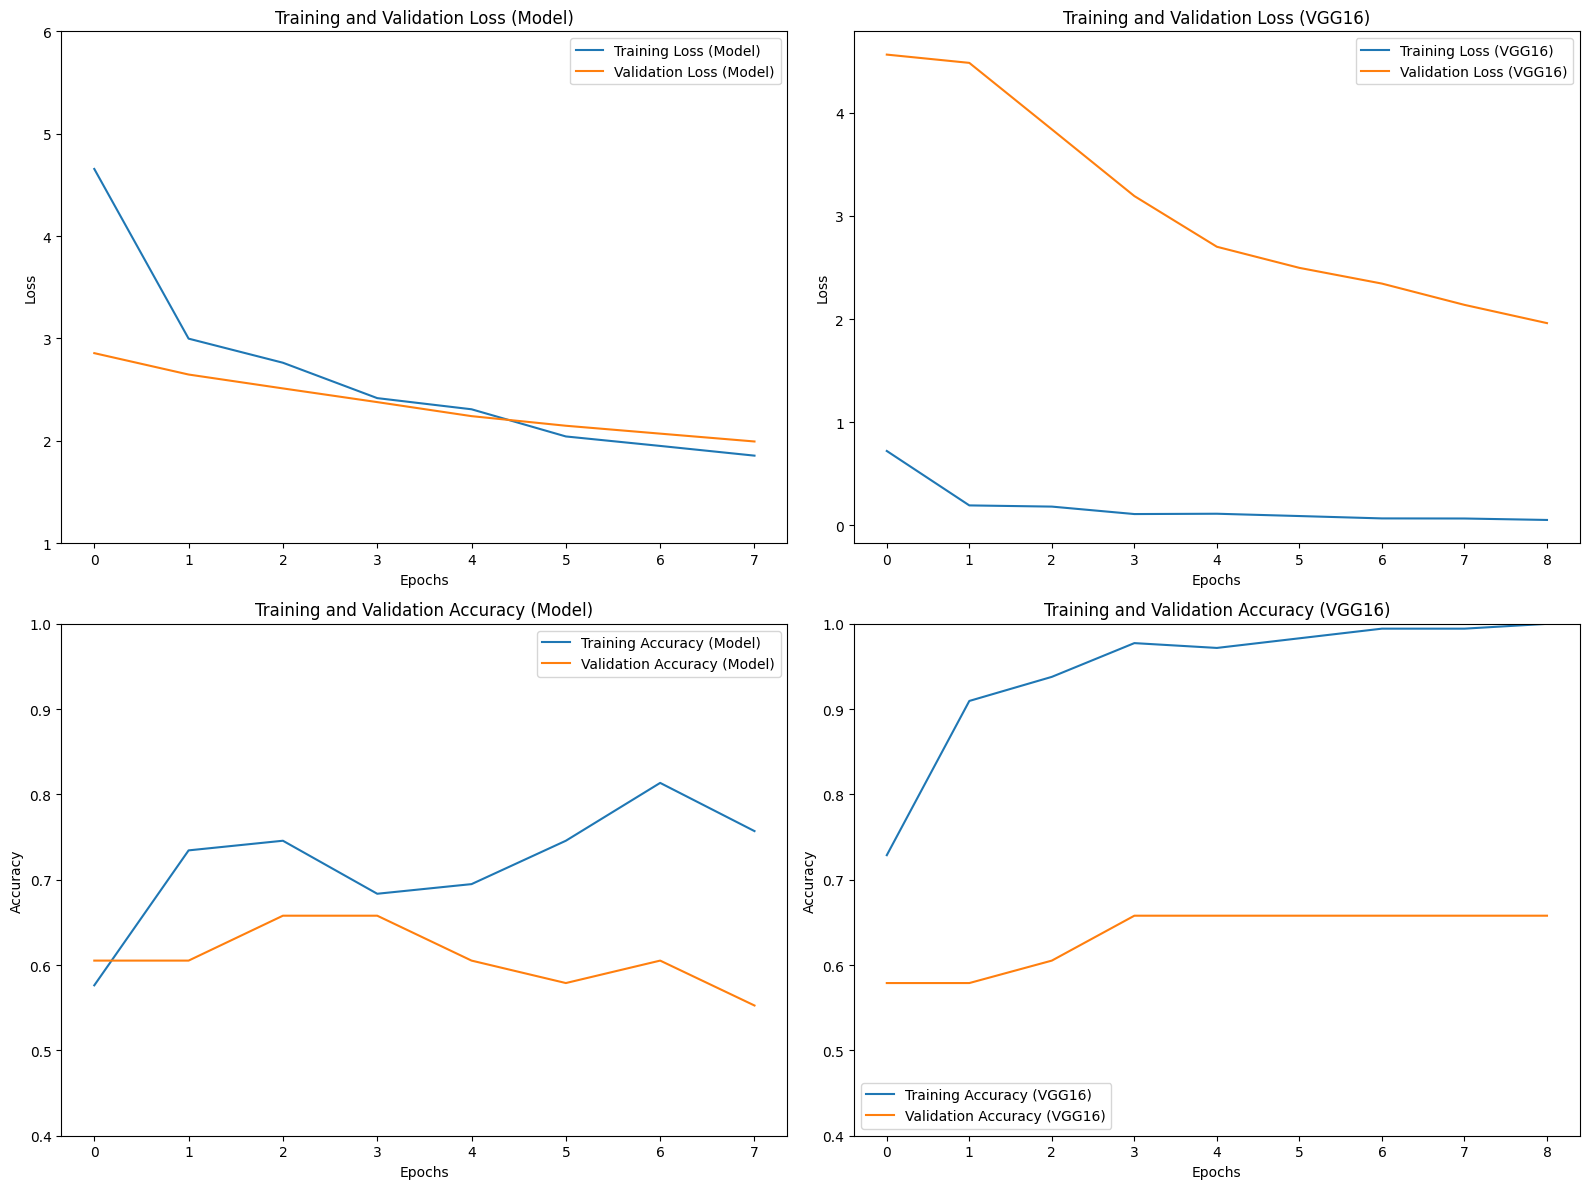

In [21]:
# Exemple d'us:
plot_training_history_dual(history, history_vgg16)